Processing round2 files in R2: 100%|██████████| 20/20 [00:02<00:00,  7.78it/s]


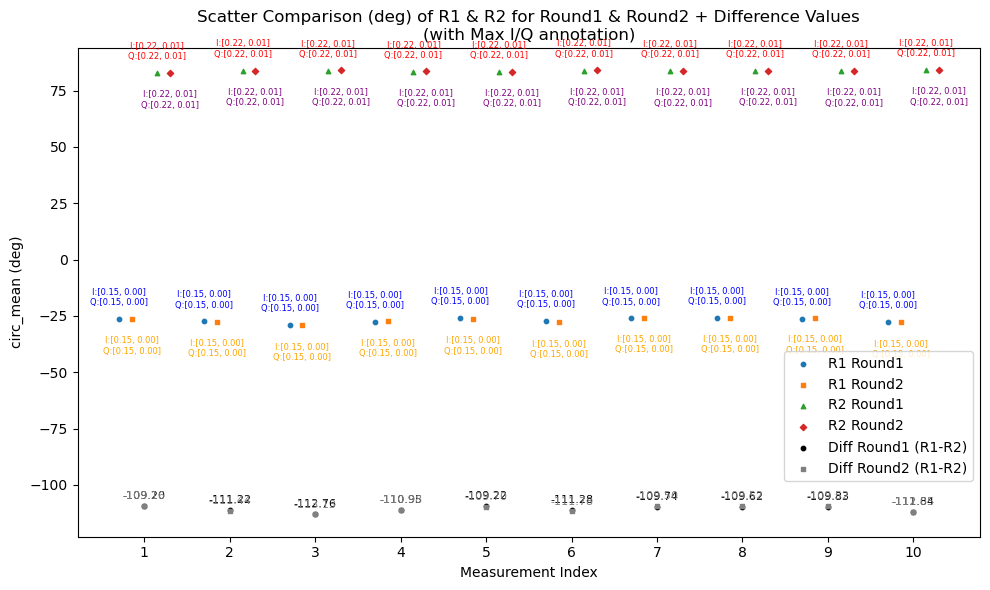

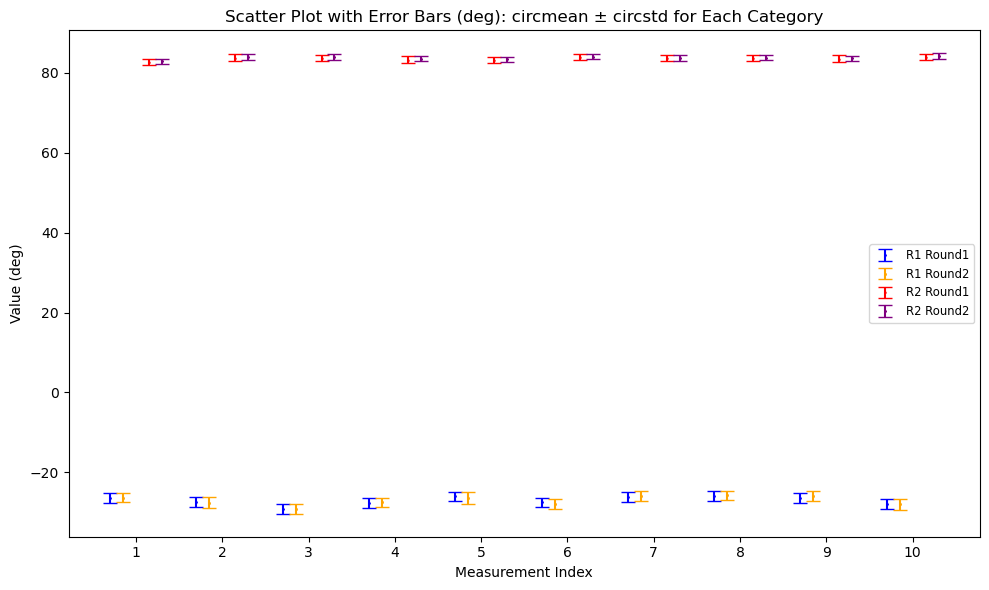

In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
import tools
from tqdm import tqdm

def parse_timestamp(filename, round_tag):
    if round_tag not in filename:
        return None
    parts = filename.split(round_tag + "_")
    if len(parts) < 2:
        return None
    timestamp_str = parts[1].replace(".npy", "")
    if not timestamp_str:
        return None
    return timestamp_str

def compute_circ_stats(iq_samples):
    phase_ch0, _ = tools.get_phases_and_apply_bandpass(iq_samples[0, :], deg=True)
    phase_ch1, _ = tools.get_phases_and_apply_bandpass(iq_samples[1, :], deg=True)
    phase_diff = tools.to_min_pi_plus_pi(phase_ch0 - phase_ch1, deg=True)
    circ_mean_val = tools.circmean(phase_diff, deg=True)
    circ_std_val = tools.circstd(phase_diff, deg=True)
    return circ_mean_val, circ_std_val

def get_max_IQ(iq_samples):
    max_I = np.max(np.abs(np.real(iq_samples)), axis=1)
    max_Q = np.max(np.abs(np.imag(iq_samples)), axis=1)
    return max_I, max_Q

def get_sorted_stats(folder_path, round_tag):
    results = []
    files = os.listdir(folder_path)
    for filename in tqdm(files, desc=f"Processing {round_tag} files in {os.path.basename(folder_path)}"):
        if filename.endswith(".npy") and round_tag in filename:
            full_path = os.path.join(folder_path, filename)
            timestamp_str = parse_timestamp(filename, round_tag)
            if not timestamp_str:
                continue
            try:
                iq_samples = np.load(full_path)
                circ_mean_val, circ_std_val = compute_circ_stats(iq_samples)
                max_I, max_Q = get_max_IQ(iq_samples)
                results.append((timestamp_str, circ_mean_val, circ_std_val, max_I, max_Q))
            except Exception as e:
                print(f"处理文件 {filename} 出错: {e}")
    results.sort(key=lambda x: x[0])
    return results

def main():
    current_dir = os.getcwd()
    r1_dir = os.path.join(current_dir, "R1")
    r2_dir = os.path.join(current_dir, "R2")

    r1_round1_stats = get_sorted_stats(r1_dir, "round1")
    r1_round2_stats = get_sorted_stats(r1_dir, "round2")
    r2_round1_stats = get_sorted_stats(r2_dir, "round1")
    r2_round2_stats = get_sorted_stats(r2_dir, "round2")

    min_len = min(len(r1_round1_stats), len(r1_round2_stats),
                  len(r2_round1_stats), len(r2_round2_stats))
    if min_len == 0:
        print("无法绘制：至少一组 round1/round2 数据为空或无法匹配。")
        return

    # 提取各类别 circmean
    r1_round1_vals = [r1_round1_stats[i][1] for i in range(min_len)]
    r1_round2_vals = [r1_round2_stats[i][1] for i in range(min_len)]
    r2_round1_vals = [r2_round1_stats[i][1] for i in range(min_len)]
    r2_round2_vals = [r2_round2_stats[i][1] for i in range(min_len)]

    # 提取各类别 max_I / max_Q
    r1_round1_maxI = [r1_round1_stats[i][3] for i in range(min_len)]
    r1_round1_maxQ = [r1_round1_stats[i][4] for i in range(min_len)]
    r1_round2_maxI = [r1_round2_stats[i][3] for i in range(min_len)]
    r1_round2_maxQ = [r1_round2_stats[i][4] for i in range(min_len)]
    r2_round1_maxI = [r2_round1_stats[i][3] for i in range(min_len)]
    r2_round1_maxQ = [r2_round1_stats[i][4] for i in range(min_len)]
    r2_round2_maxI = [r2_round2_stats[i][3] for i in range(min_len)]
    r2_round2_maxQ = [r2_round2_stats[i][4] for i in range(min_len)]

    x = np.arange(1, min_len + 1)
    offset = 0.15

    fig, ax = plt.subplots(figsize=(10, 6))
    # 散点：circmean (deg)
    ax.scatter(x - 2*offset, r1_round1_vals, marker='o', s=10, label='R1 Round1')
    ax.scatter(x -   offset, r1_round2_vals, marker='s', s=10, label='R1 Round2')
    ax.scatter(x +   offset, r2_round1_vals, marker='^', s=10, label='R2 Round1')
    ax.scatter(x + 2*offset, r2_round2_vals, marker='D', s=10, label='R2 Round2')

    # 差值散点
    diff_round1 = [r1_round1_vals[i] - r2_round1_vals[i] for i in range(min_len)]
    diff_round2 = [r1_round2_vals[i] - r2_round2_vals[i] for i in range(min_len)]
    ax.scatter(x, diff_round1, marker='o', color='black', s=10, label='Diff Round1 (R1-R2)')
    ax.scatter(x, diff_round2, marker='s', color='gray', s=10, label='Diff Round2 (R1-R2)')

    # 标注差值
    for i, val in enumerate(diff_round1):
        ax.annotate(f"{val:.2f}", (x[i], diff_round1[i]), textcoords="offset points",
                    xytext=(0, 5), ha='center', fontsize=8, color='black')
    for i, val in enumerate(diff_round2):
        ax.annotate(f"{val:.2f}", (x[i], diff_round2[i]), textcoords="offset points",
                    xytext=(0, 5), ha='center', fontsize=8, color='gray')

    # 为每个数据点标注 max_I, max_Q
    # R1 的标注在点的上方, R2 的标注在点的下方；Round1 与 Round2 也可做不同偏移
    for i in range(min_len):
        # -- R1 Round1 上方 --
        x_ = x[i] - 2*offset
        y_ = r1_round1_vals[i]
        text_r1r1 = (f"I:[{r1_round1_maxI[i][0]:.2f}, {r1_round1_maxI[i][1]:.2f}]\n"
                     f"Q:[{r1_round1_maxQ[i][0]:.2f}, {r1_round1_maxQ[i][1]:.2f}]")
        ax.annotate(text_r1r1, (x_, y_), textcoords="offset points", xytext=(0, 10),
                    ha='center', fontsize=6, color='blue')

        # -- R1 Round2 下方 --
        x_ = x[i] - offset
        y_ = r1_round2_vals[i]
        text_r1r2 = (f"I:[{r1_round2_maxI[i][0]:.2f}, {r1_round2_maxI[i][1]:.2f}]\n"
                     f"Q:[{r1_round2_maxQ[i][0]:.2f}, {r1_round2_maxQ[i][1]:.2f}]")
        ax.annotate(text_r1r2, (x_, y_), textcoords="offset points", xytext=(0, -25),
                    ha='center', fontsize=6, color='orange')

        # -- R2 Round1 上方 --
        x_ = x[i] + offset
        y_ = r2_round1_vals[i]
        text_r2r1 = (f"I:[{r2_round1_maxI[i][0]:.2f}, {r2_round1_maxI[i][1]:.2f}]\n"
                     f"Q:[{r2_round1_maxQ[i][0]:.2f}, {r2_round1_maxQ[i][1]:.2f}]")
        ax.annotate(text_r2r1, (x_, y_), textcoords="offset points", xytext=(0, 10),
                    ha='center', fontsize=6, color='red')

        # -- R2 Round2 下方 --
        x_ = x[i] + 2*offset
        y_ = r2_round2_vals[i]
        text_r2r2 = (f"I:[{r2_round2_maxI[i][0]:.2f}, {r2_round2_maxI[i][1]:.2f}]\n"
                     f"Q:[{r2_round2_maxQ[i][0]:.2f}, {r2_round2_maxQ[i][1]:.2f}]")
        ax.annotate(text_r2r2, (x_, y_), textcoords="offset points", xytext=(0, -25),
                    ha='center', fontsize=6, color='purple')

    ax.set_xticks(x)
    ax.set_xticklabels([str(i) for i in x])
    ax.set_xlabel('Measurement Index')
    ax.set_ylabel('circ_mean (deg)')
    ax.set_title('Scatter Comparison (deg) of R1 & R2 for Round1 & Round2 + Difference Values\n(with Max I/Q annotation)')
    ax.legend(loc='lower right', bbox_to_anchor=(1, 0.1))
    plt.tight_layout()
    plt.show()

    # 第二部分：误差棒散点图（不变）
    r1_r1_means = [r1_round1_stats[i][1] for i in range(min_len)]
    r1_r1_stds  = [r1_round1_stats[i][2] for i in range(min_len)]
    r1_r2_means = [r1_round2_stats[i][1] for i in range(min_len)]
    r1_r2_stds  = [r1_round2_stats[i][2] for i in range(min_len)]
    r2_r1_means = [r2_round1_stats[i][1] for i in range(min_len)]
    r2_r1_stds  = [r2_round1_stats[i][2] for i in range(min_len)]
    r2_r2_means = [r2_round2_stats[i][1] for i in range(min_len)]
    r2_r2_stds  = [r2_round2_stats[i][2] for i in range(min_len)]

    fig2, ax2 = plt.subplots(figsize=(10, 6))
    ax2.errorbar(x - 2*offset, r1_r1_means, yerr=r1_r1_stds, fmt='o', ms=1, color='blue', capsize=5, label='R1 Round1')
    ax2.errorbar(x -   offset, r1_r2_means, yerr=r1_r2_stds, fmt='s', ms=1, color='orange', capsize=5, label='R1 Round2')
    ax2.errorbar(x +   offset, r2_r1_means, yerr=r2_r1_stds, fmt='^', ms=1, color='red', capsize=5, label='R2 Round1')
    ax2.errorbar(x + 2*offset, r2_r2_means, yerr=r2_r2_stds, fmt='D', ms=1, color='purple', capsize=5, label='R2 Round2')

    ax2.set_xticks(x)
    ax2.set_xticklabels([str(i) for i in x])
    ax2.set_xlabel('Measurement Index')
    ax2.set_ylabel('Value (deg)')
    ax2.set_title('Scatter Plot with Error Bars (deg): circmean ± circstd for Each Category')
    ax2.legend(loc='best', fontsize='small')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
